## EDA

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [11]:
df = pd.read_csv('lendingclub.csv')

In [12]:
df.head()

,home_ownership,income,dti,fico,loan_status
0,1,43.0,39.66,670,0
1,1,80.0,39.54,685,1
2,0,30.0,39.52,695,1
3,1,105.0,39.45,710,0
4,0,28.6,39.28,680,1


Loan status = 0 means default and 1 means good condition. 

dti stands for disposable debt to income ratio

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2270 entries, 0 to 2269
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   home_ownership  2270 non-null   int64  
 1   income          2270 non-null   float64
 2   dti             2270 non-null   float64
 3   fico            2270 non-null   int64  
 4   loan_status     2270 non-null   int64  
dtypes: float64(2), int64(3)
memory usage: 88.8 KB


No missing values we can go on to visualization

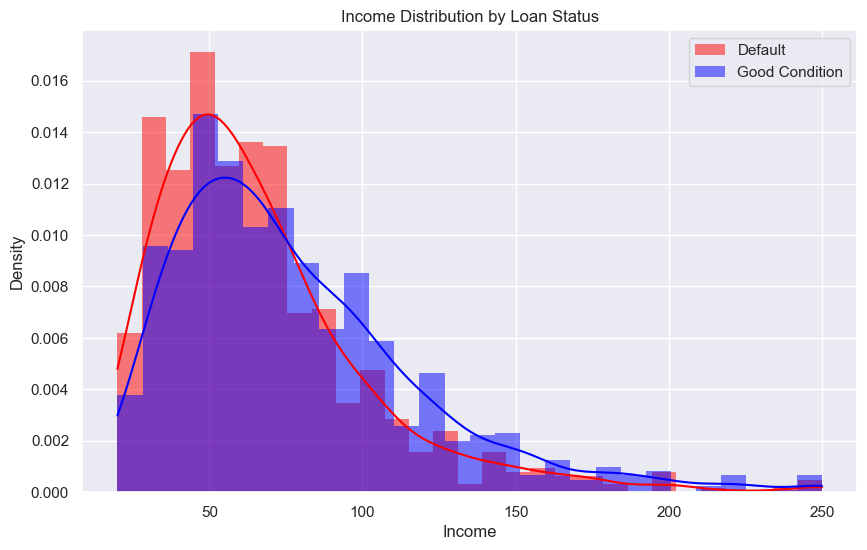

In [14]:
plt.figure(figsize=(10, 6))
sns.histplot(df[df['loan_status'] == 0]['income'], color='red', label='Default', kde=True, stat="density", linewidth=0)
sns.histplot(df[df['loan_status'] == 1]['income'], color='blue', label='Good Condition', kde=True, stat="density", linewidth=0)
plt.title('Income Distribution by Loan Status')
plt.xlabel('Income')
plt.ylabel('Density')
plt.legend()
plt.show()

This shows that there are more people with "default" status in the lower income ranges as opposed to "good condition". Specifically those individuals in the income ranges of 75-150 there are more with good condition than default. 

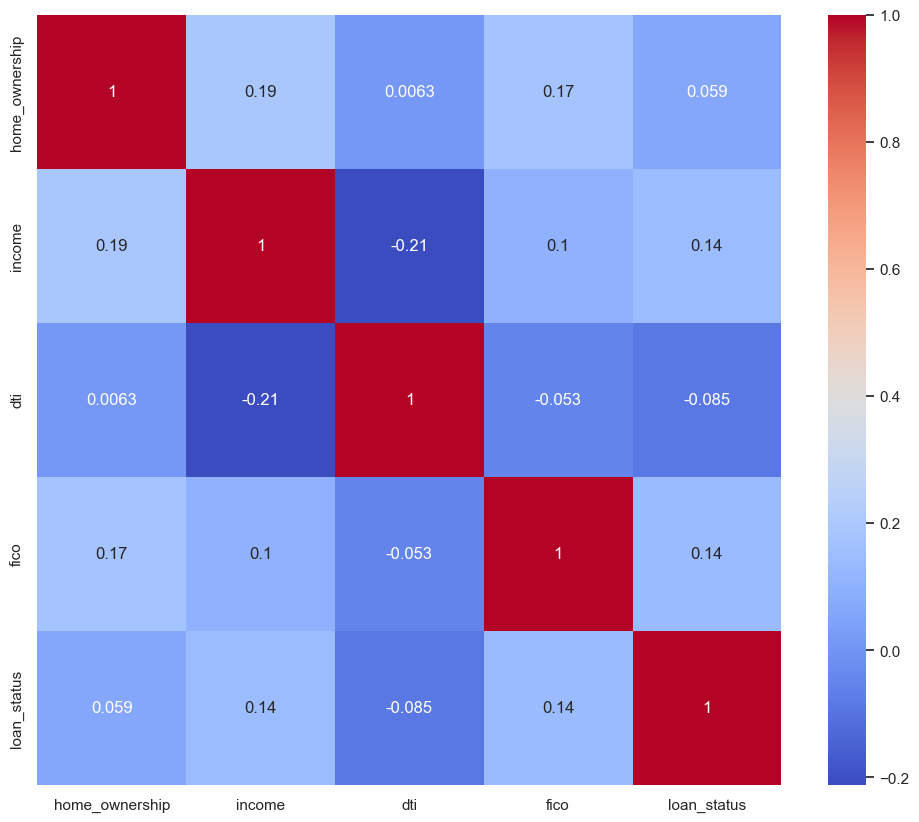

In [15]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), cmap='coolwarm',annot=True)
plt.show()

None of the variables have strong correlations with each other. This means they might not be good predictors of loan_status. We should look at getting different variables. 

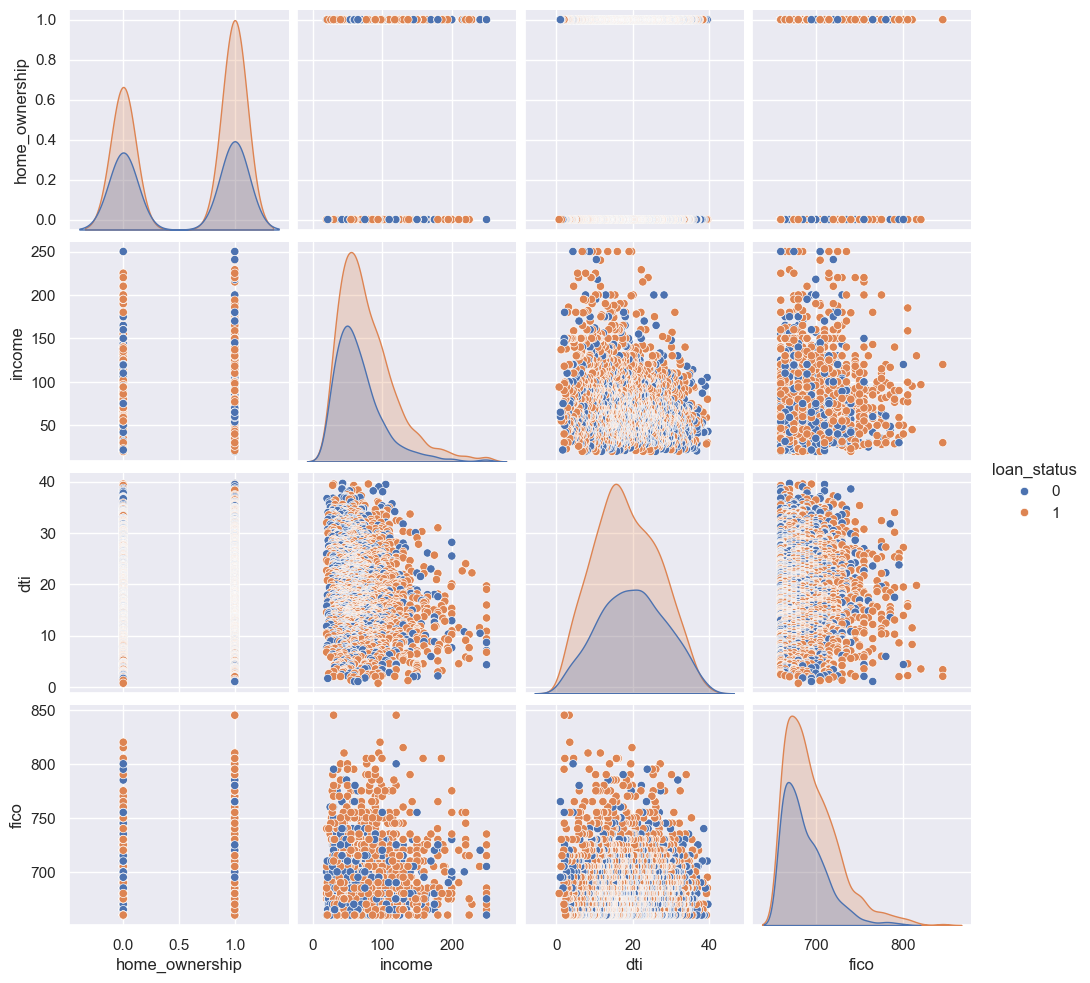

In [16]:
sns.pairplot(df, hue='loan_status')
plt.show()

I'm noticing that the data appears to be disproportional to those with a loan_status of "good condition."

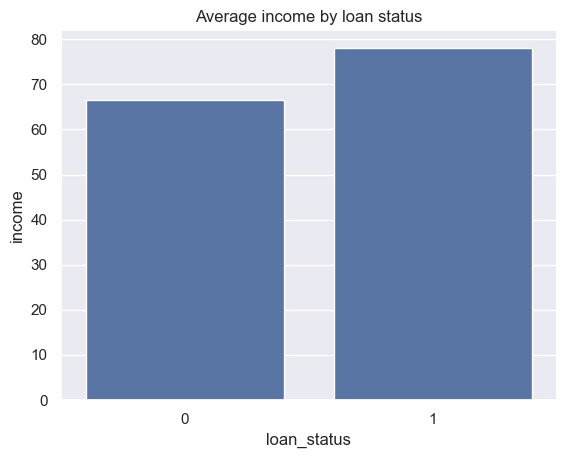

In [17]:
df_group_loan_status = df.groupby(by=['loan_status']).mean().reset_index()
sns.barplot(y='income', x='loan_status', data=df_group_loan_status)
plt.title('Average income by loan status')
plt.show()

Those with a loan_status of "good condition" have a higher average income than those that have "default" status.

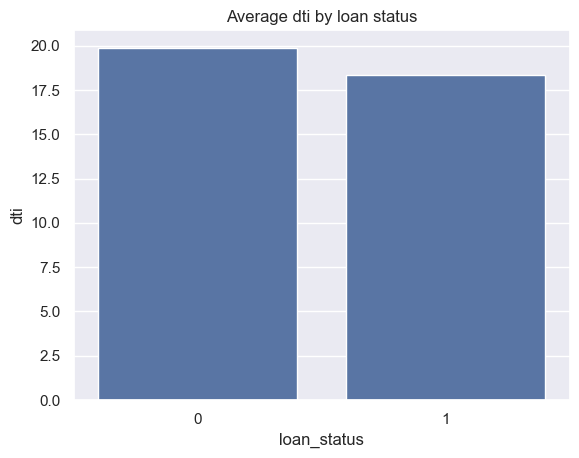

In [18]:
df_group_dti = df.groupby('loan_status')['dti'].mean().reset_index()
sns.barplot(y='dti', x='loan_status', data=df_group_dti)
plt.title('Average dti by loan status')
plt.show()

Those with a loan_status of "default" have a higher average debt to income ratio. This makes sense as they would be at risk of defaulting due to having to many bills and not enough income.

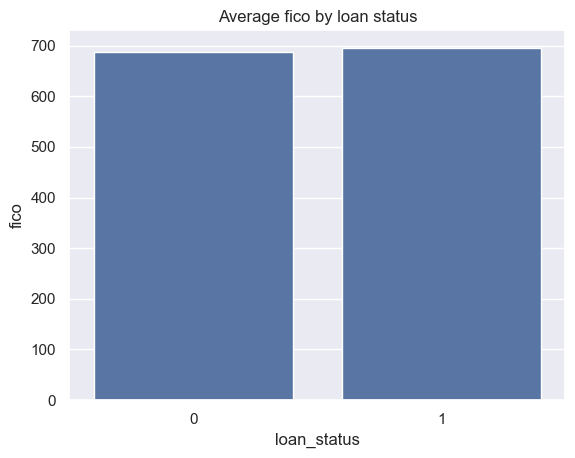

In [19]:
df_group_fico = df.groupby('loan_status')['fico'].mean().reset_index()
sns.barplot(y='fico', x='loan_status', data=df_group_fico)
plt.title('Average fico by loan status')
plt.show()

I find this interesting because the fico score is about the same for those with default and good condition indicating that it doesn't matter much. 

<Axes: xlabel='loan_status', ylabel='fico'>

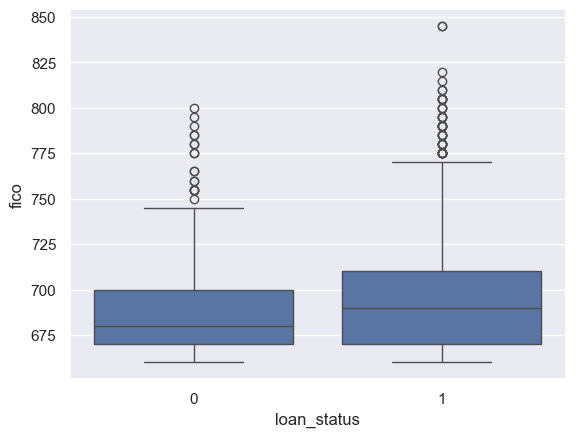

In [20]:
sns.boxplot(x='loan_status', y='fico', data=df)

I decided to review the fico scores in a boxplot and notice that those with loan_status of 1 have a higher range of fico scores. The loan status equal to 1 goes up to about 775 whereas the loan status of 0 only goes to 750. The mean is also slightly higher for the loan status of 1 than 0. 

## Classification Tree

In [21]:
pd.crosstab(df['loan_status'],df['loan_status'], normalize='all')*100

loan_status,0,1
loan_status,,
0,35.066079,0.000000
1,0.000000,64.933921


1. The data is relatively imbalanced. We have 65% of the observations showing as a loan_status of "good condition"

#### Defining Feature Space

In [22]:
y=df['loan_status']
X=df.drop('loan_status', axis=1)

rand_state = 1000

# splitting data into 80% training and 20% testing
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

In [23]:
from sklearn.tree import DecisionTreeClassifier

# training on default inputs
Tree_classifier = DecisionTreeClassifier()
Tree_classifier.fit(X_train, y_train)

DecisionTreeClassifier()

In [24]:
# Predicting the Test set classes
y_hat = Tree_classifier.predict(X_test)

#### Accuracy Metrics

In [25]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score

In [26]:
print(confusion_matrix(y_test, y_hat))

[[ 67  93]
 [107 187]]


It looks like there is a high number of false positives and false negatives

In [27]:
print(classification_report(y_test, y_hat))

              precision    recall  f1-score   support

           0       0.39      0.42      0.40       160
           1       0.67      0.64      0.65       294

    accuracy                           0.56       454
   macro avg       0.53      0.53      0.53       454
weighted avg       0.57      0.56      0.56       454



The accuracy is around 54% which is not very good. The precision which tells us the ratio of correctly predicted positive observations to the total predicted positives is around 37% for the default status. This is not good for us because we will be classifying a lot of actual defaults as good conditions. The recall which tells us the ratio of correctly predicted positive observations to all observations in the actual class is around 41% which is still not ideal. 

I don't trust these numbers as the precision and recall are low for both status.

#### Cost complexity pruning

In [28]:
Tree_classifier = DecisionTreeClassifier()
path = Tree_classifier.cost_complexity_pruning_path(X_train,y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

path

{'ccp_alphas': array([0.        , 0.0003304 , 0.00033887, 0.00034263, 0.00034263,
        0.00035042, 0.00035745, 0.00036711, 0.00036711, 0.00036711,
        0.00036711, 0.00036711, 0.00036711, 0.00036711, 0.00036711,
        0.00036711, 0.00037275, 0.000413  , 0.000413  , 0.000413  ,
        0.000413  , 0.000413  , 0.000413  , 0.000413  , 0.000413  ,
        0.00044053, 0.00044053, 0.00044053, 0.00044053, 0.00044053,
        0.00044053, 0.00044053, 0.00044053, 0.00044053, 0.00044053,
        0.00044053, 0.00044201, 0.00045054, 0.00045888, 0.00045888,
        0.00045888, 0.00045888, 0.00045888, 0.00045888, 0.00045888,
        0.00045888, 0.00045888, 0.00045888, 0.00045888, 0.00045968,
        0.00047199, 0.00047199, 0.00047199, 0.00047199, 0.00047199,
        0.00048183, 0.00048183, 0.00048183, 0.00048183, 0.00048948,
        0.00048948, 0.00048948, 0.00048948, 0.00048948, 0.00049504,
        0.00049559, 0.00049559, 0.00049559, 0.00049559, 0.00049559,
        0.0005006 , 0.00050477, 0.

In [29]:
from sklearn.model_selection import cross_val_score
import sklearn.metrics

In [30]:
ccp_alphas

array([0.        , 0.0003304 , 0.00033887, 0.00034263, 0.00034263,
       0.00035042, 0.00035745, 0.00036711, 0.00036711, 0.00036711,
       0.00036711, 0.00036711, 0.00036711, 0.00036711, 0.00036711,
       0.00036711, 0.00037275, 0.000413  , 0.000413  , 0.000413  ,
       0.000413  , 0.000413  , 0.000413  , 0.000413  , 0.000413  ,
       0.00044053, 0.00044053, 0.00044053, 0.00044053, 0.00044053,
       0.00044053, 0.00044053, 0.00044053, 0.00044053, 0.00044053,
       0.00044053, 0.00044201, 0.00045054, 0.00045888, 0.00045888,
       0.00045888, 0.00045888, 0.00045888, 0.00045888, 0.00045888,
       0.00045888, 0.00045888, 0.00045888, 0.00045888, 0.00045968,
       0.00047199, 0.00047199, 0.00047199, 0.00047199, 0.00047199,
       0.00048183, 0.00048183, 0.00048183, 0.00048183, 0.00048948,
       0.00048948, 0.00048948, 0.00048948, 0.00048948, 0.00049504,
       0.00049559, 0.00049559, 0.00049559, 0.00049559, 0.00049559,
       0.0005006 , 0.00050477, 0.0005083 , 0.0005083 , 0.00050

In [31]:
accuracy_cv =[]
for alpha in ccp_alphas:
    accuracy = cross_val_score(estimator = DecisionTreeClassifier(ccp_alpha=alpha), X = X_train, y = y_train, cv = 5 , scoring="accuracy")
    accuracy_cv.append(np.mean(accuracy))
    
output = pd.DataFrame(list(ccp_alphas), columns=['alpha'])
output['accuracy_CV']=accuracy_cv

output.head()

,alpha,accuracy_CV
0,0.000000,0.550661
1,0.000330,0.549006
2,0.000339,0.547353
3,0.000343,0.550658
4,0.000343,0.555622


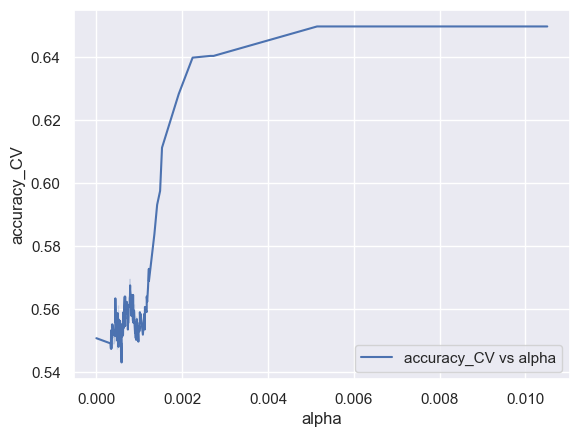

In [32]:
sns.lineplot(x='alpha', y='accuracy_CV', data=output , color='b', label="accuracy_CV vs alpha")
plt.show()

In [33]:
np.argmax(output['accuracy_CV'])

208

In [34]:
output.iloc[np.argmax(output['accuracy_CV']),]

alpha          0.005143
accuracy_CV    0.649781
Name: 208, dtype: float64

So the maximum accuracy is 65% which is identical to the score before.

In [35]:
optimal_alpha = output.iloc[np.argmax(output['accuracy_CV']),0]
optimal_alpha

0.005142538659615947

#### Refitting with the optimal alpha

In [36]:
optimal_DT = DecisionTreeClassifier(ccp_alpha=optimal_alpha)
optimal_DT.fit(X_train, y_train)
y_hat_optimized = optimal_DT.predict(X_test)

In [37]:
print(confusion_matrix(y_test, y_hat_optimized))

[[  0 160]
 [  0 294]]


In [38]:
print(classification_report(y_test, y_hat_optimized))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       160
           1       0.65      1.00      0.79       294

    accuracy                           0.65       454
   macro avg       0.32      0.50      0.39       454
weighted avg       0.42      0.65      0.51       454



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

It is now classifying everything as loan_status of 1. I believe this is happening because we are suffering from to high a bias. 

In [39]:
from sklearn.model_selection import cross_val_score

In [40]:
# remember we saved our model in an object called "Tree_classifier"
accuracy = cross_val_score(estimator = optimal_DT, X = X_train, y = y_train, cv = 5 , scoring="accuracy" )

In [41]:
accuracy

array([0.64835165, 0.65013774, 0.65013774, 0.65013774, 0.65013774])

In [42]:
round(accuracy.mean(),3)

0.65

The cross validated accuracy remains around the 65% range

#### Visualizing the Tree

In [43]:
dtree= DecisionTreeClassifier(max_depth=4, min_samples_leaf=50)
dtree.fit(X_train, y_train)
yhat = dtree.predict(X_test)

In [44]:
from sklearn.tree import plot_tree

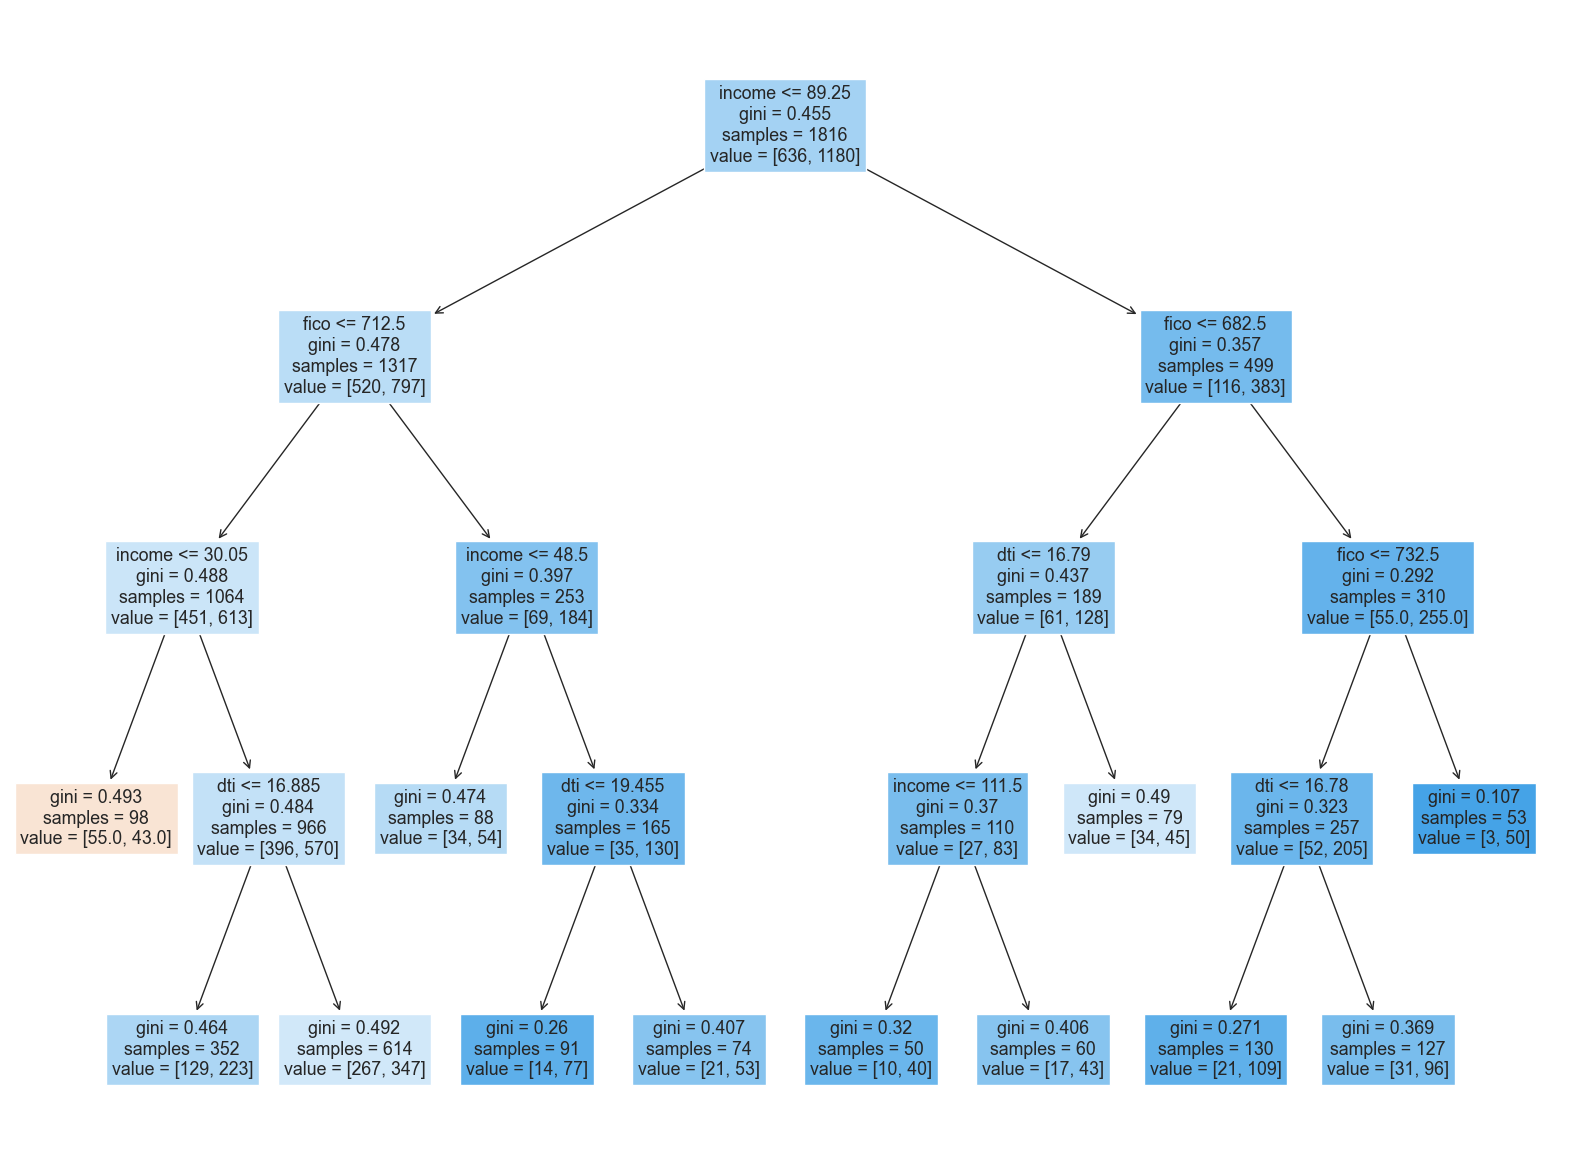

In [45]:
fig = plt.figure(figsize=(20,15))
DT_plot = plot_tree(dtree, feature_names=X_train.columns, filled=True)
# left branch True

1. The model is saying that income is the most import feature to split on. The cut off is at 
2. If income is less than 89.25, and if fico is less than 712.5, and if income is again less than 30.05 than predicted class is 0 because we have 55 observations being "default" and 43 observations being "good condition"
3. There are 9 terminal nodes which is due to us pruning the tree by setting the max depth to 4 and the minimum observations required to be in a terminal node was 50. So if for example the orange box was to be split again it the terminal nodes would contain less than 50 observations. 
4. In general i am not satisfied with the gini index at these terminal nodes. There are a few of them that are very close to 50% which is basically guessing. 